In [1]:
import os

# os.chdir('./AMLS_19-20_Muhammad_Juzaimi_SN16072927')
os.chdir('./AMLS_19-20_SN16072927')
# os.chdir('./B1')
print(os.path.abspath(os.curdir))

C:\Users\arez_\PycharmProjects\AMLS_19-20_Muhammad_Juzaimi_SN16072927\AMLS_19-20_SN16072927


In [2]:
import os
from keras.preprocessing import image
import cv2
import dlib
import numpy as np

# PATH TO ALL IMAGES
global basedir, image_paths, target_size
# os.chdir('..')
basedir = './Datasets'
images_dir = os.path.join(basedir, 'img_cartoon')
labels_filename = 'labels_cartoon.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('eyes.dat')

def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((24, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [24])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [12, 2])

    return dlibout, resized_image

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def extract_features_labels():
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
    It also extracts the gender label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        gender_labels:      an array containing the gender label (male=1 and female=0) for each image in
                            which a face was detected
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(os.path.join(basedir, labels_filename), 'r')
    lines = labels_file.readlines()
    gender_labels = {line.split('\t')[0] : int(line.split('\t')[1]) for line in lines[1:]}
    # all_features = None
    # all_labels = None
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        gambar_error = []
        for img_path in image_paths:
            file_name = img_path.split('.')[1].split('\\')[-1]

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(gender_labels[file_name])
            if features is None:
                gambar_error.append(file_name)

    landmark_features = np.array(all_features)
    gender_labels = np.array(all_labels) # simply converts the -1 into 0, so male=1 and female=0
    return landmark_features, gender_labels, gambar_error





Using TensorFlow backend.


In [3]:
import numpy as np

X, y, error = extract_features_labels()
Y = np.array([y, -(y - 1)]).T

In [4]:
print(len(X))
print(len(Y))

7815
7815


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
temp = X.reshape(len(X), 12*2)
temp_X = scaler.fit_transform(temp)
temp_Y = list(zip(*Y))[0]

In [6]:
from sklearn.model_selection import train_test_split

tr_X, te_X, tr_Y, te_Y = train_test_split(temp_X, temp_Y, test_size=0.2)
print(len(tr_X))
print(len(te_X))
print(len(tr_Y))
print(len(te_Y))

6252
1563
6252
1563


In [7]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

def SVM_B1(training_images, training_labels, test_images, test_labels):
    tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100]},
                        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                        {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100]}
                        ]


    classifierB1 = GridSearchCV(svm.SVC(), tuned_parameters, n_jobs=-1, cv=10)  # gridsearchCV use 3 k-fold by default
    classifierB1.fit(training_images, training_labels)
    print(classifierB1.best_params_)
# default score of SVM is accuracy
    acc_B1_train = classifierB1.best_score_
    
    cv_score = classifierB1.cv_results_

# prediction using best classifier choose by GridSearchCV
    predB1 = classifierB1.best_estimator_.predict(test_images)

    acc_B1_test = accuracy_score(test_labels, predB1)
    
    return acc_B1_train, acc_B1_test, predB1, cv_score

In [8]:
import time
starttime = time.time()
model_B1 = SVM_B1(tr_X, tr_Y, te_X, te_Y)
stoptime = time.time()
print(stoptime - starttime)

{'C': 100, 'degree': 3, 'kernel': 'poly'}


413.4373643398285


In [9]:
acc_B1_train, acc_B1_test, predB1, cv_score = model_B1
print(acc_B1_train, acc_B1_test)

0.4712079233226837 0.49200255918106206


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

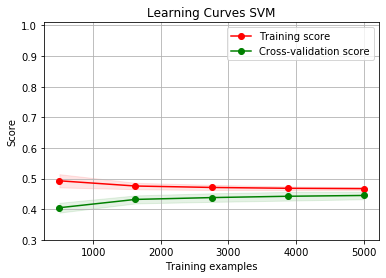

In [11]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves SVM"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = svm.SVC(kernel='rbf', gamma=1e-3, C=100)
X, y = tr_X, tr_Y
plot_learning_curve(estimator, title, X, y, (0.3, 1.01), cv=cv, n_jobs=-1)

plt.show()

# default test score for SVM is accuracy

[[163  31  59  16  23]
 [ 61 100  82  50  12]
 [ 62  64 123  40  16]
 [ 35  77  64 132  17]
 [ 37  22  14  12 251]]


<function matplotlib.pyplot.show(*args, **kw)>

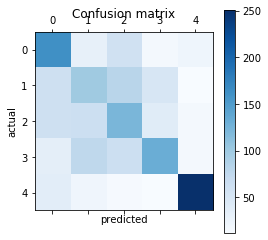

In [12]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

test_label = te_Y
cf = confusion_matrix(test_label, predB1)
print(cf)

cmap = plt.cm.Blues

plt.matshow(cf, cmap = cmap)
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show

In [21]:
print(error)

['1', '10', '100', '1005', '1011', '1016', '1018', '102', '1020', '1036', '1042', '1043', '1048', '1049', '1056', '1068', '1082', '1092', '1094', '1095', '1098', '11', '1100', '1104', '1108', '1109', '1110', '1122', '1128', '1132', '1134', '1139', '114', '1141', '1144', '1147', '115', '1154', '1156', '1159', '1163', '1164', '117', '1174', '1175', '1177', '1178', '1181', '1190', '1191', '1192', '1198', '1199', '12', '1201', '1204', '1209', '1211', '1217', '1218', '1231', '1260', '1262', '1264', '1267', '1269', '1272', '1274', '1278', '1283', '1293', '1294', '1295', '1299', '1302', '1303', '1311', '1313', '1318', '1326', '1329', '1334', '1336', '1337', '1340', '1341', '1342', '1356', '1362', '1366', '137', '1371', '1374', '1376', '1377', '1386', '1388', '1389', '1390', '1394', '1400', '1403', '1414', '1416', '1418', '1425', '1426', '143', '1436', '1443', '1445', '1459', '1462', '1463', '1469', '1474', '1477', '1481', '1483', '1487', '1491', '1494', '1499', '1515', '1518', '152', '1524', 

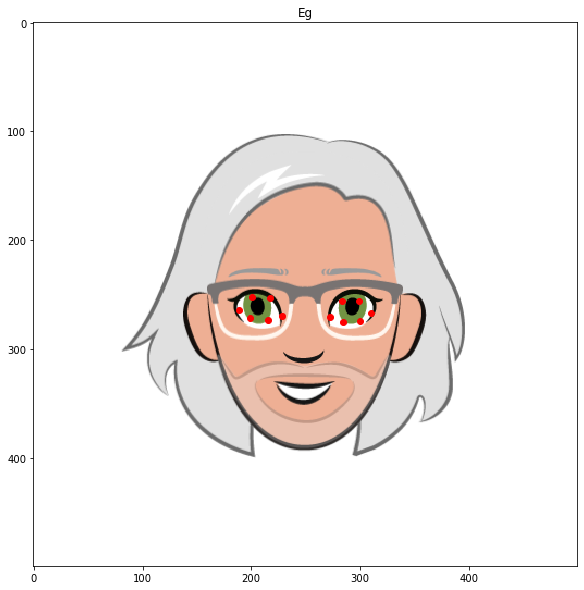

In [13]:
import matplotlib.pyplot as plt

basedir = './Datasets'
images_dir = os.path.join(basedir, 'img_cartoon')
ex_img_path = os.path.join(images_dir, '20.png')
ex_img = image.img_to_array(image.load_img(ex_img_path, target_size = None, interpolation='bicubic'))
ex_feat, _ = run_dlib_shape(ex_img)



x, y = np.split(ex_feat, 2, axis=1)
cv_image = cv2.imread(ex_img_path)
fig = plt.figure(figsize=(10, 10))
image_plot = plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
plt.title("Eg")
plt.scatter(x, y, c='red')
plt.show()